### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import psycopg
import mlflow
from dotenv import load_dotenv
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostRegressor

In [5]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}

load_dotenv()

TABLE_NAME = 'clean_flats_churn'

postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"), 
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)


with psycopg.connect(**connection) as conn:


    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")

        data = cur.fetchall()

        columns = [col[0] for col in cur.description]


data = pd.DataFrame(data, columns=columns)

In [6]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "mle-project-sprint-2-v001"

RANDOM_STATE = 42

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('AWS_SECRET_ACCESS_KEY')

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

RUN_NAME = 'baseline'
MODEL_REGISTRY_NAME = 'sprint-2-model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    model_path = '../models/fitted_model.pkl'
    with open(model_path, 'rb') as f:
        model = joblib.load(f)

    mlflow.sklearn.log_model(sk_model=model, artifact_path="pipeline_model", registered_model_name=MODEL_REGISTRY_NAME)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

ASSETS_DIR = "assets"

/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.4.1.post1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv/lib/python3.10/site-packages/sklearn/base.

#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [7]:
data.head(10)

,id,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,50968,3,False,9.7,18.900000,1,False,35.000000,10000000.0,1988,4,55.886028,37.658363,2.48,474,16,True
1,50969,11,False,8.4,18.100000,1,False,38.400002,9900000.0,2014,4,55.604900,37.361435,2.75,372,17,True
2,50970,7,False,9.0,33.000000,2,False,53.000000,16500000.0,1970,1,55.829334,37.587299,2.70,112,14,True
3,50971,4,False,8.9,31.299999,2,False,46.900002,14500000.0,1967,6,55.805401,37.572514,2.64,80,12,True
4,50975,12,True,7.0,18.000000,1,False,30.000000,17900000.0,2017,2,55.755783,37.509819,3.00,90,25,True
5,50976,8,False,6.0,30.000000,2,False,46.000000,12300000.0,1967,1,55.793613,37.778828,2.64,108,9,True
6,50978,3,False,10.0,30.000000,2,False,49.000000,20000000.0,1965,1,55.757927,37.573814,2.60,72,9,True
7,50979,8,False,10.0,48.000000,3,False,75.000000,15000000.0,1988,4,55.876789,37.709469,2.64,208,14,True
8,50981,11,False,8.4,17.100000,1,False,38.099998,9400000.0,2008,4,55.550758,37.570644,2.64,195,14,True
9,50982,7,False,14.0,32.900002,2,False,58.000000,14500000.0,2014,2,55.587772,37.456944,2.80,160,9,True


In [8]:
data.nunique()

id                   103493
floor                    20
is_apartment              2
kitchen_area            530
living_area            1347
rooms                     5
studio                    1
total_area             1770
price                  3913
build_year              105
building_type_int         6
latitude              14363
longitude             14007
ceiling_height           35
flats_count             589
floors_total             29
has_elevator              2
dtype: int64

In [9]:
data_info = data.info()

numerical_description = data.describe()

missing_values = data.isnull().sum()

unique_values = data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103493 entries, 0 to 103492
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 103493 non-null  int64  
 1   floor              103493 non-null  int64  
 2   is_apartment       103493 non-null  bool   
 3   kitchen_area       103493 non-null  float64
 4   living_area        103493 non-null  float64
 5   rooms              103493 non-null  int64  
 6   studio             103493 non-null  bool   
 7   total_area         103493 non-null  float64
 8   price              103493 non-null  object 
 9   build_year         103493 non-null  int64  
 10  building_type_int  103493 non-null  int64  
 11  latitude           103493 non-null  float64
 12  longitude          103493 non-null  float64
 13  ceiling_height     103493 non-null  float64
 14  flats_count        103493 non-null  int64  
 15  floors_total       103493 non-null  int64  
 16  ha

In [25]:
data['price'] = data['price'].astype(float)

In [26]:
missing_values, numerical_description, unique_values

(id                   0
 floor                0
 is_apartment         0
 kitchen_area         0
 living_area          0
 rooms                0
 studio               0
 total_area           0
 price                0
 build_year           0
 building_type_int    0
 latitude             0
 longitude            0
 ceiling_height       0
 flats_count          0
 floors_total         0
 has_elevator         0
 dtype: int64,
                   id          floor   kitchen_area    living_area   
 count  103493.000000  103493.000000  103493.000000  103493.000000  \
 mean    68546.243253       6.726039       8.101251      27.533055   
 std     41104.240116       4.508221       2.986849      14.425440   
 min         0.000000       1.000000       0.000000       0.000000   
 25%     32623.000000       3.000000       6.000000      19.000000   
 50%     67293.000000       6.000000       8.400000      28.400000   
 75%    103651.000000       9.000000      10.000000      36.000000   
 max    141361.00

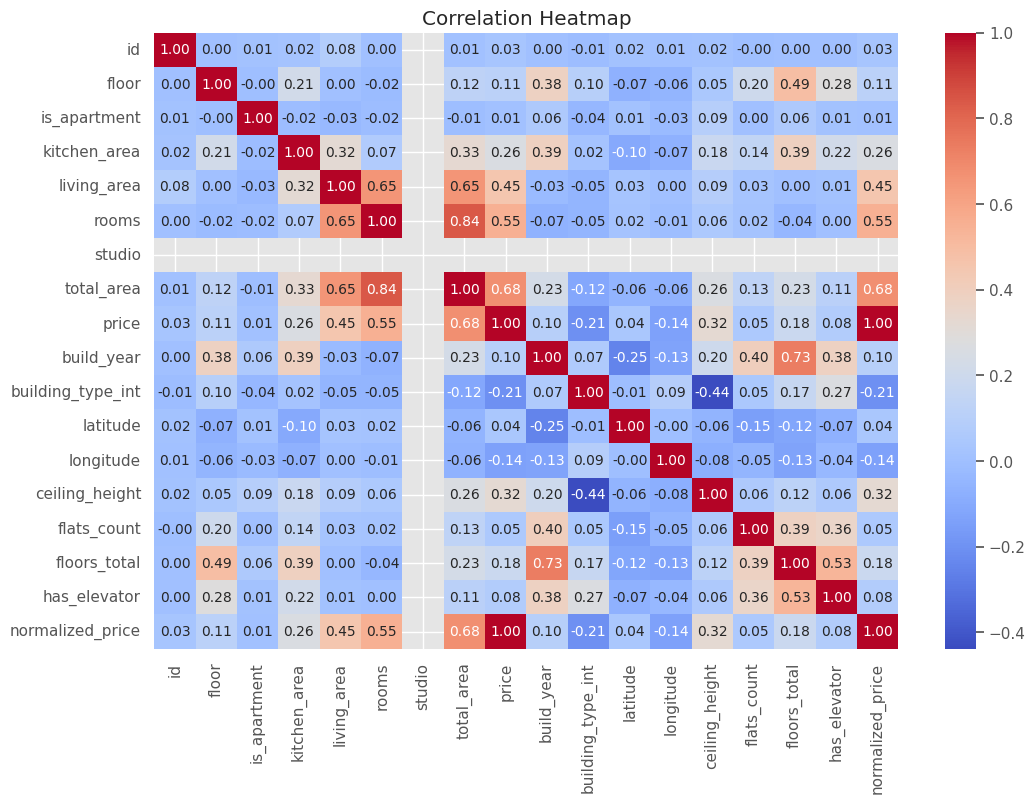

In [27]:
# 2.3 Анализ признаков для модели
plt.style.use('ggplot')

plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

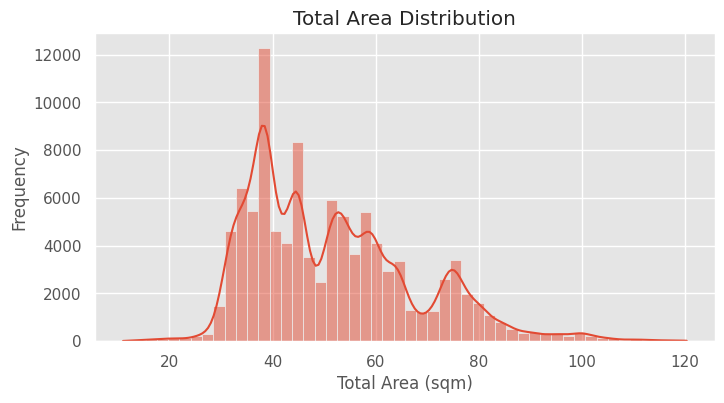

In [28]:
plt.figure(figsize=(8, 4))
sns.histplot(data['total_area'], bins=50, kde=True)
plt.title('Total Area Distribution')
plt.xlabel('Total Area (sqm)')
plt.ylabel('Frequency')
plt.show()

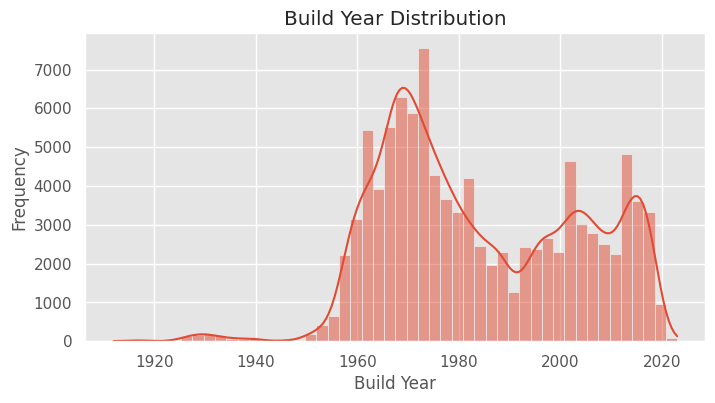

In [29]:
plt.figure(figsize=(8, 4))
sns.histplot(data['build_year'], bins=50, kde=True)
plt.title('Build Year Distribution')
plt.xlabel('Build Year')
plt.ylabel('Frequency')
plt.show()

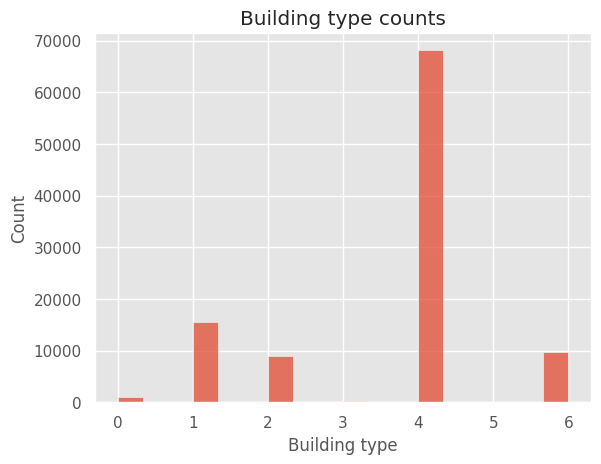

In [30]:
sns.histplot(data['building_type_int'])
plt.title('Building type counts')
plt.xlabel('Building type')
plt.ylabel('Count')
plt.show()

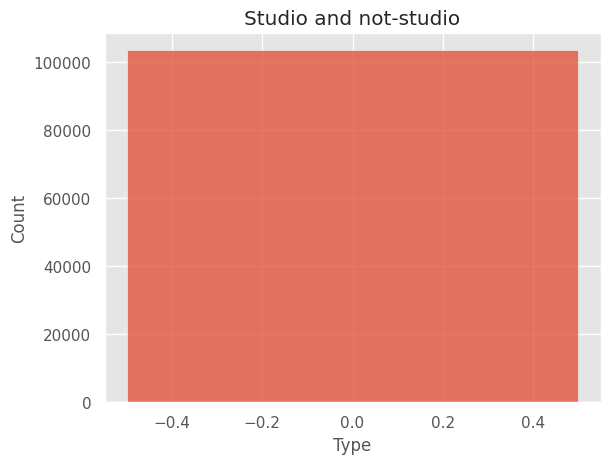

In [31]:
sns.histplot(data['studio'])
plt.title('Studio and not-studio')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

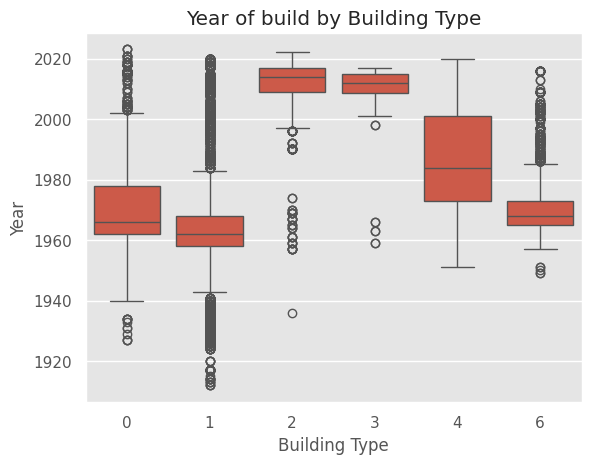

In [32]:
sns.boxplot(x='building_type_int', y='build_year', data=data)
plt.title('Year of build by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Year')
plt.show()

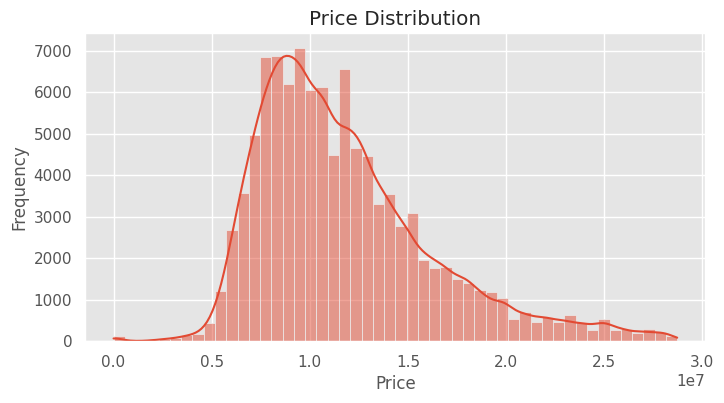

In [33]:
# Анализ целевой переменной
plt.figure(figsize=(8, 4))
sns.histplot(data['price'], bins=50, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [34]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

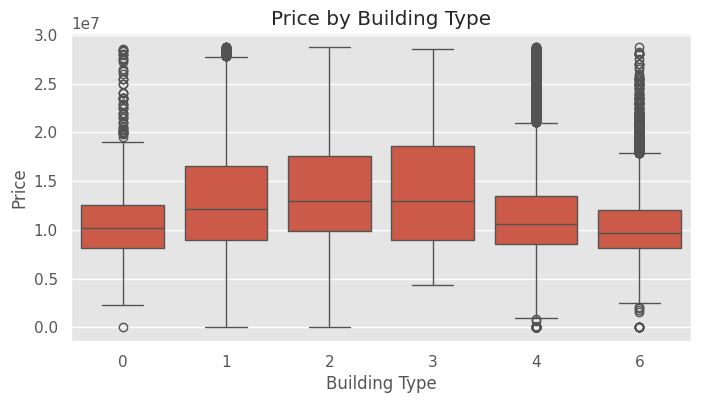

In [35]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='building_type_int', y='price', data=data)
plt.title('Price by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Price')
plt.show()

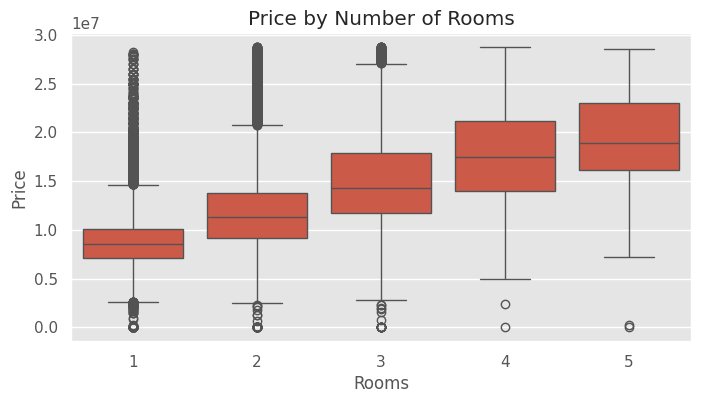

In [36]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='rooms', y='price', data=data)
plt.title('Price by Number of Rooms')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

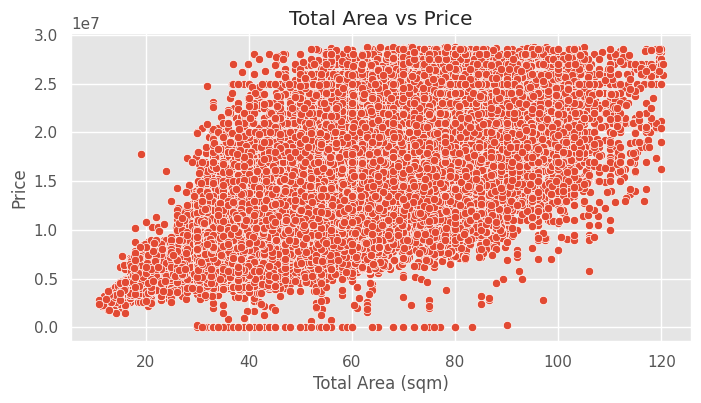

In [37]:

plt.figure(figsize=(8, 4))
sns.scatterplot(x='total_area', y='price', data=data)
plt.title('Total Area vs Price')
plt.xlabel('Total Area (sqm)')
plt.ylabel('Price')
plt.show()

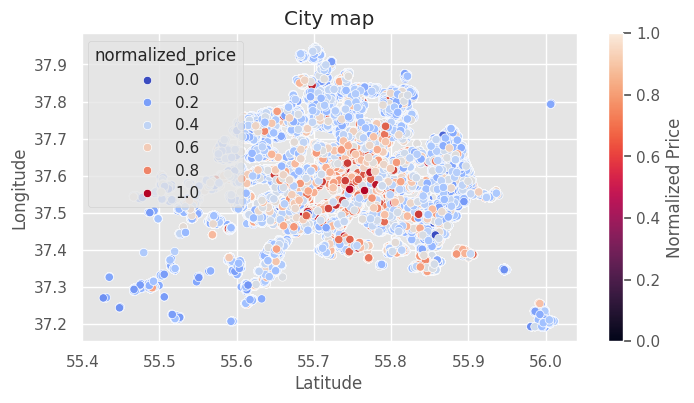

In [38]:
data['normalized_price'] = (data['price'] - data['price'].min()) / (data['price'].max() - data['price'].min())
plt.figure(figsize=(8, 4))
scatter = sns.scatterplot(x='latitude', y='longitude', hue='normalized_price', palette='coolwarm', data=data)
plt.title('City map')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(scatter.collections[0], label='Normalized Price')
plt.show()
data = data.drop(columns=['normalized_price'])

In [39]:
# 2.5 Выводы после EDA

In [40]:
# 2.6 логирование артефактов в MLflow
RUN_NAME = 'eda'
NOTEBOOK_PATH = 'project_template_sprint_2.ipynb'
MARDOWN_PATH = 'conclusions.md'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifact(NOTEBOOK_PATH, artifact_path="notebooks")
    mlflow.log_artifact(MARDOWN_PATH, artifact_path="outputs")
    mlflow.log_artifacts(ASSETS_DIR) 
    print(f"Logged run with ID: {run.info.run_id}")

Logged run with ID: 0718d44243e547b4b9fc2bb0b0f312ac


#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [41]:
# 3.1 ручная генерация признаков

In [42]:
class CustomFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mean_longitude = None
        self.mean_latitude = None

    def fit(self, X, y=None):
        self.mean_longitude = X['longitude'].mean()
        self.mean_latitude = X['latitude'].mean()
        return self

    def transform(self, X):
        X = X.copy()
        
        X['distance_to_center'] = (X['longitude'] - self.mean_longitude) ** 2 + (X['latitude'] - self.mean_latitude) ** 2
        
        X['space_per_room'] = X['total_area'] / X['rooms']
        
        X['kitchen_total_area'] = X['kitchen_area'] / X['total_area']
        X['living_total_area'] = X['living_area'] / X['total_area']
        
        X['high_floor'] = X['floor'] > (X['floors_total'] / 2)

        X['age'] = 2024 - X['build_year']

        X['flats_density'] = X['flats_count'] / X['floors_total']

        
        return X

In [43]:
def get_cat_features(data):
    return list(data.nunique()[data.nunique() < 7].index)

def get_num_features(data):
    return [x for x in data.columns if x not in get_cat_features(data) and x != 'price']

In [44]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, cat_features):
        self.feature_names = feature_names
        self.cat_features = cat_features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(X, columns=self.feature_names)

        for feature in self.cat_features:
            df[feature] = df[feature].astype(int)
        
        return df

def create_model_pipeline(data, needed_features=[], model_params={'random_state': 42}):
    
    preprocessor = Pipeline(steps=[
        ('drop_studio', FunctionTransformer(lambda X: X.drop(columns=['studio'], errors='ignore'))),
        ('custom_features', CustomFeaturesTransformer())
    ])

    transformed_data = preprocessor.fit_transform(data)
    
    if needed_features:
        num_features = [x for x in get_num_features(pd.DataFrame(transformed_data)) if x in needed_features]
        cat_features = [x for x in get_cat_features(pd.DataFrame(transformed_data)) if x in needed_features]
    else:
        num_features = get_num_features(pd.DataFrame(transformed_data))
        cat_features = get_cat_features(pd.DataFrame(transformed_data))


    column_transformer = ColumnTransformer(transformers=[
            ('ordinal_encoder', OrdinalEncoder(), cat_features),
            ('standard_scaler', StandardScaler(), num_features)],
            remainder='drop')

    full_preprocessor = Pipeline(steps=[
        ('custom_features', preprocessor),
        ('column_transformer', column_transformer),
        ('to_df', ToDataFrameTransformer(feature_names=cat_features + num_features, cat_features=cat_features))
    ])

    # Преобразуем данные и выводим результат
    preprocessed_data = full_preprocessor.fit_transform(data)

    model_pipeline = Pipeline(steps=[
        ('preprocessor', full_preprocessor),
        ('regressor', CatBoostRegressor(**model_params, cat_features=cat_features))
    ])

    return model_pipeline

In [45]:
# 3.4 обучение новой версии модели
model_pipeline = create_model_pipeline(data)

metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error']

cv_strategy = KFold(n_splits=3)

cv_res = cross_validate(
    model_pipeline,
    data.drop(columns=['price']),
    data['price'],
    cv=cv_strategy,
    n_jobs=-1,
    scoring=metrics
)

for key, value in cv_res.items():
    cv_res[key] = round(value.mean(), 3)  

print(cv_res)

Learning rate set to 0.079931
Learning rate set to 0.079931
0:	learn: 4313749.3607314	total: 145ms	remaining: 2m 24s
0:	learn: 4279535.5023312	total: 144ms	remaining: 2m 24s
1:	learn: 4104032.3144133	total: 229ms	remaining: 1m 54s
1:	learn: 4140851.5756113	total: 231ms	remaining: 1m 55s
2:	learn: 3983186.7519191	total: 326ms	remaining: 1m 48s
2:	learn: 3946366.4624867	total: 325ms	remaining: 1m 47s
3:	learn: 3842570.5450819	total: 416ms	remaining: 1m 43s
3:	learn: 3806777.4428954	total: 418ms	remaining: 1m 44s
4:	learn: 3721545.1634099	total: 516ms	remaining: 1m 42s
4:	learn: 3678641.4507907	total: 519ms	remaining: 1m 43s
5:	learn: 3610671.6477684	total: 604ms	remaining: 1m 40s
5:	learn: 3565264.6627438	total: 608ms	remaining: 1m 40s
6:	learn: 3510735.3384551	total: 684ms	remaining: 1m 37s
6:	learn: 3462886.1055610	total: 686ms	remaining: 1m 37s
7:	learn: 3372373.0872183	total: 769ms	remaining: 1m 35s
7:	learn: 3422404.0119703	total: 767ms	remaining: 1m 35s
8:	learn: 3290597.3427381	to

In [46]:
model_pipeline.fit(data.drop(columns=['price']), data['price'])

Learning rate set to 0.085219
0:	learn: 4300125.2342094	total: 108ms	remaining: 1m 47s
1:	learn: 4111862.9030063	total: 172ms	remaining: 1m 25s
2:	learn: 3950646.7661124	total: 232ms	remaining: 1m 16s
3:	learn: 3806442.5286799	total: 294ms	remaining: 1m 13s
4:	learn: 3676527.0274210	total: 355ms	remaining: 1m 10s
5:	learn: 3559154.4728030	total: 412ms	remaining: 1m 8s
6:	learn: 3460041.6096196	total: 473ms	remaining: 1m 7s
7:	learn: 3371059.1584968	total: 537ms	remaining: 1m 6s
8:	learn: 3294044.7390623	total: 591ms	remaining: 1m 5s
9:	learn: 3224788.9827108	total: 640ms	remaining: 1m 3s
10:	learn: 3159139.8959927	total: 702ms	remaining: 1m 3s
11:	learn: 3100495.5420759	total: 759ms	remaining: 1m 2s
12:	learn: 3050036.6300828	total: 812ms	remaining: 1m 1s
13:	learn: 3001827.2609235	total: 866ms	remaining: 1m 1s
14:	learn: 2960507.3646434	total: 927ms	remaining: 1m
15:	learn: 2924807.4896237	total: 986ms	remaining: 1m
16:	learn: 2891285.1522055	total: 1.05s	remaining: 1m
17:	learn: 2861

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('custom_features',
                                  Pipeline(steps=[('drop_studio',
                                                   FunctionTransformer(func=<function create_model_pipeline.<locals>.<lambda> at 0x7f22b0f1f370>)),
                                                  ('custom_features',
                                                   CustomFeaturesTransformer())])),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   ['is_apartment',
                                                                    'r...
                                                                        'building_type_int',
                                                                        'has_elevator',
                                                                        'high_floor',
                                                                        'id',
                                                                        'floor',
                                                                        'kitchen_area',
                                                                        'living_area',
                                                                        'total_area',
                                                                        'build_year',
                                                                        'latitude',
                                                                        'longitude',
                                                                        'ceiling_height',
                                                                        'flats_count',
                                                                        'floors_total',
                                                                        'distance_to_center',
                                                                        'space_per_room',
                                                                        'kitchen_total_area',
                                                                        'living_total_area',
                                                                        'age',
                                                                        'flats_density']))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f22b19f3b80>)])

In [47]:
# 3.5 логирование артефактов в MLflow
RUN_NAME = 'feature_generation'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    for metric_name, score in cv_res.items():
        mlflow.log_metric(metric_name, score)
    mlflow.sklearn.log_model(model_pipeline, "model")

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [48]:
preprocessor = model_pipeline.named_steps['preprocessor']

transformed_data = preprocessor.transform(data.drop(columns=['price']))

cat_features = preprocessor.named_steps['column_transformer'].transformers_[0][1].get_feature_names_out()

num_features = preprocessor.named_steps['column_transformer'].transformers_[1][1].get_feature_names_out()

feature_names = np.concatenate([cat_features, num_features])

In [49]:
# 4.1 Отбор признаков при помощи метода номер 1
feature_importances = model_pipeline.named_steps['regressor'].feature_importances_

mean_importance = np.median(feature_importances)

importance_mask = feature_importances > mean_importance

selected_features_1 = feature_names[importance_mask]

selected_features_1

array(['id', 'kitchen_area', 'total_area', 'build_year', 'latitude',
       'longitude', 'ceiling_height', 'floors_total',
       'distance_to_center', 'space_per_room', 'age'], dtype=object)

In [50]:
# 4.2 Отбор признаков при помощи метода номер 2
from sklearn.inspection import permutation_importance

model_pipeline.fit(data.drop(columns=['price']), data['price'])

regressor = model_pipeline.named_steps['regressor']

results = permutation_importance(regressor, transformed_data, data['price'], n_repeats=5, random_state=42)

# Получаем отсортированную важность
sorted_idx = results.importances_mean.argsort()[::-1]
print("Feature ranking:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {results.importances_mean[i]:.3f}")

Learning rate set to 0.085219
0:	learn: 4300125.2342094	total: 57.8ms	remaining: 57.7s
1:	learn: 4111862.9030063	total: 129ms	remaining: 1m 4s
2:	learn: 3950646.7661124	total: 190ms	remaining: 1m 3s
3:	learn: 3806442.5286799	total: 252ms	remaining: 1m 2s
4:	learn: 3676527.0274210	total: 316ms	remaining: 1m 2s
5:	learn: 3559154.4728030	total: 373ms	remaining: 1m 1s
6:	learn: 3460041.6096196	total: 430ms	remaining: 1m 1s
7:	learn: 3371059.1584968	total: 493ms	remaining: 1m 1s
8:	learn: 3294044.7390623	total: 549ms	remaining: 1m
9:	learn: 3224788.9827108	total: 603ms	remaining: 59.7s
10:	learn: 3159139.8959927	total: 677ms	remaining: 1m
11:	learn: 3100495.5420759	total: 733ms	remaining: 1m
12:	learn: 3050036.6300828	total: 788ms	remaining: 59.9s
13:	learn: 3001827.2609235	total: 847ms	remaining: 59.7s
14:	learn: 2960507.3646434	total: 940ms	remaining: 1m 1s
15:	learn: 2924807.4896237	total: 1.03s	remaining: 1m 3s
16:	learn: 2891285.1522055	total: 1.09s	remaining: 1m 3s
17:	learn: 2861703.

Learning rate set to 0.079931
Learning rate set to 0.079931
0:	learn: 4279535.5023312	total: 85.5ms	remaining: 1m 25s
0:	learn: 4313749.3607314	total: 73.6ms	remaining: 1m 13s
1:	learn: 4104032.3144133	total: 173ms	remaining: 1m 26s
1:	learn: 4140851.5756113	total: 156ms	remaining: 1m 17s
2:	learn: 3983186.7519191	total: 251ms	remaining: 1m 23s
2:	learn: 3946366.4624867	total: 302ms	remaining: 1m 40s
3:	learn: 3842570.5450819	total: 420ms	remaining: 1m 44s
3:	learn: 3806777.4428954	total: 449ms	remaining: 1m 51s
4:	learn: 3721545.1634099	total: 563ms	remaining: 1m 51s
4:	learn: 3678641.4507907	total: 588ms	remaining: 1m 56s
5:	learn: 3565264.6627438	total: 672ms	remaining: 1m 51s
5:	learn: 3610671.6477684	total: 658ms	remaining: 1m 49s
6:	learn: 3462886.1055610	total: 750ms	remaining: 1m 46s
6:	learn: 3510735.3384551	total: 733ms	remaining: 1m 43s
7:	learn: 3372373.0872183	total: 824ms	remaining: 1m 42s
7:	learn: 3422404.0119703	total: 814ms	remaining: 1m 40s
8:	learn: 3290597.3427381	

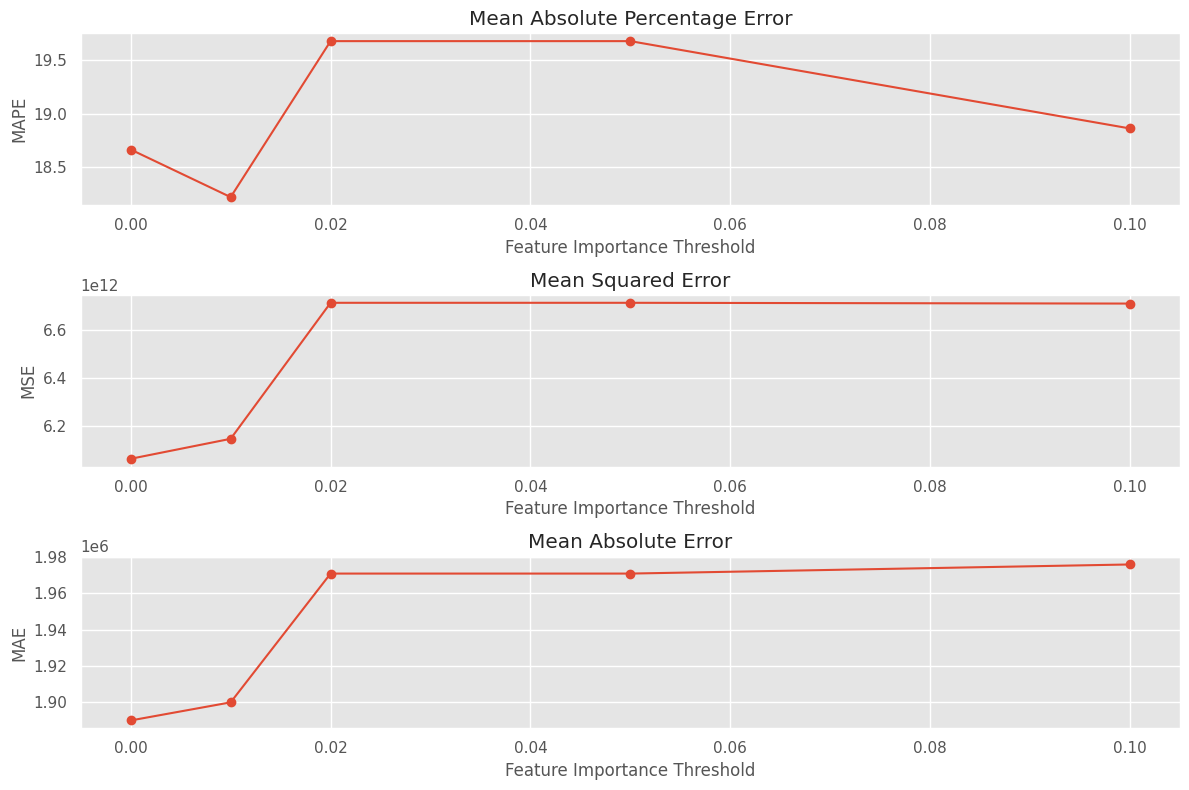

In [51]:
thresholds = np.array([0, 0.01, 0.02, 0.05, 0.1])

mape_scores = []
mse_scores = []
mae_scores = []

metrics = ['neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_absolute_error']

cv_strategy = KFold(n_splits=3)

for threshold in thresholds:

    importance_mask = results.importances_mean >= threshold
    selected_features = list(feature_names[importance_mask])

    model_pipeline = create_model_pipeline(data, selected_features)

    cv_res = cross_validate(
        model_pipeline,
        data.drop(columns=['price']),
        data['price'],
        cv=cv_strategy,
        n_jobs=-1,
        scoring=metrics
    )
    mape_scores.append(-cv_res['test_neg_mean_absolute_percentage_error'].mean())
    mse_scores.append(-cv_res['test_neg_mean_squared_error'].mean())
    mae_scores.append(-cv_res['test_neg_mean_absolute_error'].mean())

plt.figure(figsize=(12, 8))

# График для MAPE
plt.subplot(3, 1, 1)
plt.plot(thresholds, mape_scores, label='MAPE', marker='o')
plt.title('Mean Absolute Percentage Error')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('MAPE')

# График для MSE
plt.subplot(3, 1, 2)
plt.plot(thresholds, mse_scores, label='MSE', marker='o')
plt.title('Mean Squared Error')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('MSE')

# График для MAE
plt.subplot(3, 1, 3)
plt.plot(thresholds, mae_scores, label='MAE', marker='o')
plt.title('Mean Absolute Error')
plt.xlabel('Feature Importance Threshold')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

In [52]:
importance_mask = results.importances_mean >= 0.01
selected_features = list(feature_names[importance_mask])

model_pipeline = create_model_pipeline(data, selected_features)

model_pipeline.fit(data.drop(columns=['price']), data['price'])

Learning rate set to 0.085219
0:	learn: 4299995.7362933	total: 123ms	remaining: 2m 2s
1:	learn: 4116305.0477079	total: 232ms	remaining: 1m 55s
2:	learn: 3953002.5066348	total: 301ms	remaining: 1m 39s
3:	learn: 3806120.6866395	total: 349ms	remaining: 1m 26s
4:	learn: 3676048.2449685	total: 407ms	remaining: 1m 21s
5:	learn: 3559710.2765912	total: 476ms	remaining: 1m 18s
6:	learn: 3457860.5069071	total: 514ms	remaining: 1m 12s
7:	learn: 3367386.0230424	total: 557ms	remaining: 1m 9s
8:	learn: 3287427.6193392	total: 601ms	remaining: 1m 6s
9:	learn: 3216453.5657058	total: 641ms	remaining: 1m 3s
10:	learn: 3156806.2871797	total: 685ms	remaining: 1m 1s
11:	learn: 3100012.7671384	total: 729ms	remaining: 1m
12:	learn: 3046630.2255592	total: 771ms	remaining: 58.5s
13:	learn: 3000337.8002326	total: 809ms	remaining: 57s
14:	learn: 2961992.1993108	total: 858ms	remaining: 56.4s
15:	learn: 2927808.4670973	total: 898ms	remaining: 55.2s
16:	learn: 2893216.1979755	total: 937ms	remaining: 54.2s
17:	learn:

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('custom_features',
                                  Pipeline(steps=[('drop_studio',
                                                   FunctionTransformer(func=<function create_model_pipeline.<locals>.<lambda> at 0x7f22b0fadbd0>)),
                                                  ('custom_features',
                                                   CustomFeaturesTransformer())])),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   ['rooms']),
                                                                  ('stand...
                                                                    'living_total_area',
                                                                    'age'])])),
                                 ('to_df',
                                  ToDataFrameTransformer(cat_features=['rooms'],
                                                         feature_names=['rooms',
                                                                        'id',
                                                                        'floor',
                                                                        'kitchen_area',
                                                                        'living_area',
                                                                        'total_area',
                                                                        'build_year',
                                                                        'latitude',
                                                                        'longitude',
                                                                        'floors_total',
                                                                        'distance_to_center',
                                                                        'space_per_room',
                                                                        'living_total_area',
                                                                        'age']))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f22b1aaf6a0>)])

In [53]:
# 4.5 Логирование всех артефактов в MLflow

In [54]:
RUN_NAME = 'feature_selection'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.log_param("selected_features", selected_features)
    mlflow.log_param("importance_threshold", 0.01)
    mlflow.log_metric("MAPE", mape_scores[1])
    mlflow.log_metric("MSE", mse_scores[1])
    mlflow.log_metric("MAE", mae_scores[1])
    mlflow.sklearn.log_model(model_pipeline, "model_after_feature_selection")

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [55]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1


param_dist = {
    'regressor__iterations': [100, 200, 500],
    'regressor__depth': [4, 6, 8, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__l2_leaf_reg': [1, 3, 5, 7],
    'regressor__border_count': [32, 64, 128],
    'regressor__random_strength': [1, 2, 5],
    'regressor__bagging_temperature': [0, 0.5, 1],
    'regressor__verbose': [False]
}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
}

random_search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring=scoring,
    refit='MAPE',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(data.drop(columns=['price']), data['price'])

print(random_search.best_params_)

{'regressor__verbose': False, 'regressor__random_strength': 1, 'regressor__learning_rate': 0.1, 'regressor__l2_leaf_reg': 5, 'regressor__iterations': 500, 'regressor__depth': 10, 'regressor__border_count': 64, 'regressor__bagging_temperature': 1}


In [56]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        'iterations': trial.suggest_categorical('iterations', [100, 200, 500]),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 7),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        'random_strength': trial.suggest_int('random_strength', 1, 5),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_state': 42,
        'verbose': False
    }

    model = create_model_pipeline(data, selected_features, param)
    
    mape = cross_val_score(model, data.drop(columns=['price']), data['price'], 
                           cv=3, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
    
    return -np.mean(mape)

study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=20)

print(study.best_trial.params)

[I 2024-10-11 16:31:57,689] A new study created in memory with name: no-name-7b02741e-5052-4b30-ab83-673c2f5532db
[I 2024-10-11 16:32:06,226] Trial 0 finished with value: 19.33813945532735 and parameters: {'iterations': 100, 'depth': 7, 'learning_rate': 0.056133152519669605, 'l2_leaf_reg': 5, 'border_count': 128, 'random_strength': 1, 'bagging_temperature': 0.3494831371832662}. Best is trial 0 with value: 19.33813945532735.
[I 2024-10-11 16:32:33,779] Trial 1 finished with value: 18.215808633256266 and parameters: {'iterations': 200, 'depth': 9, 'learning_rate': 0.09115015557233713, 'l2_leaf_reg': 6, 'border_count': 32, 'random_strength': 5, 'bagging_temperature': 0.16437871714752106}. Best is trial 1 with value: 18.215808633256266.
[I 2024-10-11 16:32:41,732] Trial 2 finished with value: 18.44030490761446 and parameters: {'iterations': 100, 'depth': 7, 'learning_rate': 0.04298201685887364, 'l2_leaf_reg': 2, 'border_count': 32, 'random_strength': 4, 'bagging_temperature': 0.94269603129

{'iterations': 500, 'depth': 8, 'learning_rate': 0.09535278625922178, 'l2_leaf_reg': 3, 'border_count': 32, 'random_strength': 5, 'bagging_temperature': 0.1727066811622397}


In [57]:
# 5.3 Формирование списка гиперпараметров для новой модели
params = study.best_trial.params

In [58]:
# 5.4 Обуение финальной версии модели
model_pipeline = create_model_pipeline(data, selected_features, params)
model_pipeline.fit(data.drop(columns=['price']), data['price'])

0:	learn: 4286672.0393074	total: 60.1ms	remaining: 30s
1:	learn: 4095445.3905437	total: 107ms	remaining: 26.5s
2:	learn: 3919544.4143712	total: 162ms	remaining: 26.8s
3:	learn: 3771352.5057945	total: 211ms	remaining: 26.1s
4:	learn: 3627370.4020760	total: 264ms	remaining: 26.1s
5:	learn: 3503964.0368016	total: 325ms	remaining: 26.8s
6:	learn: 3395518.0000187	total: 412ms	remaining: 29s
7:	learn: 3304072.6617384	total: 465ms	remaining: 28.6s
8:	learn: 3223752.3455795	total: 517ms	remaining: 28.2s
9:	learn: 3145947.2520632	total: 573ms	remaining: 28.1s
10:	learn: 3084054.7907748	total: 621ms	remaining: 27.6s
11:	learn: 3028633.3857922	total: 679ms	remaining: 27.6s
12:	learn: 2975623.8754329	total: 735ms	remaining: 27.6s
13:	learn: 2930387.3758696	total: 791ms	remaining: 27.4s
14:	learn: 2893417.8801100	total: 844ms	remaining: 27.3s
15:	learn: 2857127.7508210	total: 893ms	remaining: 27s
16:	learn: 2829118.5762498	total: 952ms	remaining: 27.1s
17:	learn: 2807219.5126855	total: 1.01s	remain

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('custom_features',
                                  Pipeline(steps=[('drop_studio',
                                                   FunctionTransformer(func=<function create_model_pipeline.<locals>.<lambda> at 0x7f22b0f1f1c0>)),
                                                  ('custom_features',
                                                   CustomFeaturesTransformer())])),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('ordinal_encoder',
                                                                   OrdinalEncoder(),
                                                                   ['rooms']),
                                                                  ('stand...
                                                                    'living_total_area',
                                                                    'age'])])),
                                 ('to_df',
                                  ToDataFrameTransformer(cat_features=['rooms'],
                                                         feature_names=['rooms',
                                                                        'id',
                                                                        'floor',
                                                                        'kitchen_area',
                                                                        'living_area',
                                                                        'total_area',
                                                                        'build_year',
                                                                        'latitude',
                                                                        'longitude',
                                                                        'floors_total',
                                                                        'distance_to_center',
                                                                        'space_per_room',
                                                                        'living_total_area',
                                                                        'age']))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f22b2983eb0>)])

In [59]:
# 5.5 Логирование артефактов в MLflow
RUN_NAME = 'parameter_tuning'
with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.log_params(random_search.best_params_)
    mlflow.log_params(study.best_trial.params)
    mlflow.log_metric("RandomSearch_Best_MAPE", -random_search.best_score_)
    mlflow.sklearn.log_model(model_pipeline, "final_model")